# Sumarização

Fonte: https://github.com/gkamradt/langchain-tutorials

A sumarização é um alicerce fundamental de muitas tarefas do LLM. Freqüentemente, você encontrará casos de uso em que gostaria de resumir um grande corpo de texto em um conjunto sucinto de pontos.

Dependendo do tamanho do texto que você deseja resumir, você pode escolher entre diferentes métodos de resumo.

In [1]:
from dotenv import load_dotenv
import os
load_dotenv()

from langchain.chat_models import AzureChatOpenAI # Abstraction for ChatGPT API endpoint
from langchain.embeddings import OpenAIEmbeddings

llm = AzureChatOpenAI(
    openai_api_type=os.getenv('AZOPENAI_API_TYPE'),
    openai_api_key=os.getenv('AZOPENAI_API_KEY'),
    openai_api_base=os.getenv('AZOPENAI_API_BASE'),
    openai_api_version=os.getenv('AZOPENAI_DEPLOYMENT_VERSION'),
    deployment_name=os.getenv('AZOPENAI_DEPLOYMENT_NAME'),
    model=os.getenv('AZOPENAI_MODEL_NAME'),
)

embeddings_model = OpenAIEmbeddings(
        deployment=os.getenv('AZOPENAI_EMBEDDINGS_DEPLOYMENT_NAME'),
        openai_api_key=os.getenv('AZOPENAI_API_KEY'),
        openai_api_base=os.getenv('AZOPENAI_API_BASE'),
        openai_api_version=os.getenv('AZOPENAI_DEPLOYMENT_VERSION'),
        openai_api_type='azure',
        model='text-embedding-ada-002',
        chunk_size=1,
        client="chatcontas"
    )



## Nível 1: Prompt Básico - Resuma algumas frases

Se você tiver apenas algumas frases que deseja resumir, você pode usar um prompt simples e copiar e colar seu texto.

Este método não é escalável e prático apenas para alguns casos de uso.

O importante é fornecer instruções para que o LLM saiba o que fazer. Neste caso estou dizendo ao modelo que quero um resumo do texto abaixo.

In [2]:
from langchain.prompts import ChatPromptTemplate, HumanMessagePromptTemplate

prompt_template = HumanMessagePromptTemplate.from_template("Forneça um resumo do seguinte texto\n TEXTO: {texto}")
chat_template = ChatPromptTemplate.from_messages([prompt_template])

texto = """
Filosofia (do grego: φιλοσοφία, philosophia, 'amor à sabedoria') \
é o estudo sistematizado de questões gerais e fundamentais, \
como aqueles sobre existência, razão, conhecimento, valores, mente e linguagem. \
Algumas fontes afirmam que o termo foi cunhado por Pitágoras (c. 570 – c. 495 aC), \
embora esta teoria seja contestada por alguns. Os métodos filosóficos incluem questionamento, \
discussão crítica, argumento racional e apresentação sistemática.
"""

In [3]:
chat_prompt = chat_template.format_messages(texto=texto)
llm(chat_prompt)

AIMessage(content='O texto apresenta uma definição de filosofia como o estudo sistemático de questões gerais e fundamentais relacionadas à existência, razão, conhecimento, valores, mente e linguagem. O termo teria sido cunhado por Pitágoras, mas esta teoria é contestada por alguns. Os métodos filosóficos envolvem questionamento, discussão crítica, argumento racional e apresentação sistemática.', additional_kwargs={}, example=False)

In [4]:
prompt = chat_prompt[0].content
print(prompt)


Forneça um resumo do seguinte texto
 TEXTO: 
Filosofia (do grego: φιλοσοφία, philosophia, 'amor à sabedoria') é o estudo sistematizado de questões gerais e fundamentais, como aqueles sobre existência, razão, conhecimento, valores, mente e linguagem. Algumas fontes afirmam que o termo foi cunhado por Pitágoras (c. 570 – c. 495 aC), embora esta teoria seja contestada por alguns. Os métodos filosóficos incluem questionamento, discussão crítica, argumento racional e apresentação sistemática.



In [5]:
num_tokens = llm.get_num_tokens(prompt)
print (f"O prompt tem {num_tokens} tokens")

O prompt tem 155 tokens


## Nível 2: Map Reduce - Resuma algumas páginas em várias páginas

Se você tiver várias páginas que gostaria de resumir, provavelmente atingirá um limite de tokens. Os limites de token nem sempre serão um problema, mas é bom saber como lidar com eles caso você se depare com o problema.

O tipo de chain "Map Reduce" é um método que ajuda nisso. Primeiro você gera um resumo de partes menores (que cabem no limite de token) e depois obtém um resumo dos resumos.

In [6]:
from langchain.chains.summarize import load_summarize_chain
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [8]:
from langchain.document_loaders import PyPDFLoader

arquivo = '../dados/relatorio_auditoria_TC_011165_2022_RTC_97_2022.pdf'
loader = PyPDFLoader(arquivo)
docs = loader.load()
len(docs)

32

In [9]:
[doc.page_content.strip() for doc in docs]

['TRIBUNAL DE CONTAS DO ESTADO DO PARÁ                        Secretaria de Controle Externo - 1ª CCG 1\nRELATÓRIO DE \nAUDITORIA \nPROGRAMADAPROCESSO: 011165/2022ÓRGÃO: Tribunal de Contas dos \nMunicípios do Estado do Pará – \nTCM/PA  e Fundo de Modernização, \nReaparelhamento e Aperfeiçoamento do \nTribunal de Contas dos Municípios do \nEstado do Pará - FUMREAPEXERCÍCIO: 2021RESPONSÁVEL: Exma. Sra. \nConselheira Presidente  Mara Lúcia \nBarbalho da Cruz (14/01/2021 a \n31/12/2023)Setembro/2022',
 'TRIBUNAL DE CONTAS DO ESTADO DO PARÁ                                                         Secretaria de Controle Externo – 1ª CCG 2 SUMÁRIO 1. IDENTIFICAÇÃO DA FISCALIZAÇÃO.........................................................32. INFORMAÇÕES SOBRE O ÓRGÃO AUDITADO.........................................32.1. Responsáveis pela administração do órgão no exercício auditado...................32.2. Unidades Gestoras:.........................................................................

In [10]:
texto = ' \n'.join([doc.page_content.strip() for doc in docs])
print(texto[:1000])

TRIBUNAL DE CONTAS DO ESTADO DO PARÁ                        Secretaria de Controle Externo - 1ª CCG 1
RELATÓRIO DE 
AUDITORIA 
PROGRAMADAPROCESSO: 011165/2022ÓRGÃO: Tribunal de Contas dos 
Municípios do Estado do Pará – 
TCM/PA  e Fundo de Modernização, 
Reaparelhamento e Aperfeiçoamento do 
Tribunal de Contas dos Municípios do 
Estado do Pará - FUMREAPEXERCÍCIO: 2021RESPONSÁVEL: Exma. Sra. 
Conselheira Presidente  Mara Lúcia 
Barbalho da Cruz (14/01/2021 a 
31/12/2023)Setembro/2022 
TRIBUNAL DE CONTAS DO ESTADO DO PARÁ                                                         Secretaria de Controle Externo – 1ª CCG 2 SUMÁRIO 1. IDENTIFICAÇÃO DA FISCALIZAÇÃO.........................................................32. INFORMAÇÕES SOBRE O ÓRGÃO AUDITADO.........................................32.1. Responsáveis pela administração do órgão no exercício auditado...................32.2. Unidades Gestoras:.........................................................................................

Vamos ver quantos tokens existem no documento

In [11]:
llm.get_num_tokens(texto)

25681

São muitos, vamos dividir nosso texto em partes para que caibam no limite do prompt. Vou usar um bloco de 10.000 caracteres.

In [12]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(separators=["\n\n", "\n"], chunk_size=10000, chunk_overlap=500)
docs = text_splitter.create_documents([texto])


In [13]:
num_docs = len(docs)

num_tokens_first_doc = llm.get_num_tokens(docs[0].page_content)

print (f"Agora temos {num_docs} documentos e o primeiro possui {num_tokens_first_doc} tokens")

Agora temos 9 documentos e o primeiro possui 2758 tokens


Ótimo, supondo que o número de tokens seja consistente nos outros documentos, estaremos prontos para prosseguir. Vamos usar o [load_summarize_chain](https://python.langchain.com/en/latest/use_cases/summarization.html) do LangChain para fazer o `map_reduce` para nós. Primeiro precisamos inicializar nossa chain.

In [14]:
from langchain.chains.summarize import load_summarize_chain

summary_chain = load_summarize_chain(llm=llm, chain_type='map_reduce', verbose=True)

In [15]:
output = summary_chain.run(docs)



> Entering new MapReduceDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Write a concise summary of the following:


"TRIBUNAL DE CONTAS DO ESTADO DO PARÁ                        Secretaria de Controle Externo - 1ª CCG 1
RELATÓRIO DE 
AUDITORIA 
PROGRAMADAPROCESSO: 011165/2022ÓRGÃO: Tribunal de Contas dos 
Municípios do Estado do Pará – 
TCM/PA  e Fundo de Modernização, 
Reaparelhamento e Aperfeiçoamento do 
Tribunal de Contas dos Municípios do 
Estado do Pará - FUMREAPEXERCÍCIO: 2021RESPONSÁVEL: Exma. Sra. 
Conselheira Presidente  Mara Lúcia 
Barbalho da Cruz (14/01/2021 a 
31/12/2023)Setembro/2022 
TRIBUNAL DE CONTAS DO ESTADO DO PARÁ                                                         Secretaria de Controle Externo – 1ª CCG 2 SUMÁRIO 1. IDENTIFICAÇÃO DA FISCALIZAÇÃO.........................................................32. INFORMAÇÕES SOBRE O ÓRGÃO AUDITADO.........................................32.1. Responsáveis pela administração do órgã

In [16]:
output

'The Tribunal de Contas do Estado do Pará conducted an audit on the Tribunal de Contas dos Municípios do Estado do Pará and the Fundo de Modernização, Reaparelhamento e Aperfeiçoamento do Tribunal de Contas dos Municípios do Estado do Pará for the year 2021. The audit found that the accounts were properly managed and executed in compliance with legal and contractual requirements. The report includes information on the audited organization, objectives of the audit, and results of the investigation into various aspects such as remittance of accounts, budget execution, and selected contracts. The report also provides details on the responsible parties and includes electronic signatures from three external auditors.'

In [17]:
# Checando o prompt default
print(summary_chain.llm_chain.prompt.template)
print("------")
print(summary_chain.combine_document_chain.llm_chain.prompt.template)

Write a concise summary of the following:


"{text}"


CONCISE SUMMARY:
------
Write a concise summary of the following:


"{text}"


CONCISE SUMMARY:


In [18]:
from langchain.prompts import PromptTemplate

map_custom_prompt='''Resuma o seguinte texto de forma clara e concisa:TEXTO: ```{text}``` Resumo:'''
map_prompt_template = PromptTemplate (
    input_variables=['text'],
    template=map_custom_prompt
)

combine_custom_prompt='''Gere um resumo do seguinte texto que inclua os seguintes elementos:
- Um título que reflita com precisão o conteúdo do texto.
- Um parágrafo de introdução que forneça uma visão geral do tópico.
- Marcadores que listem os pontos principais do texto.
- Um parágrafo de conclusão que resume os pontos principais do texto.

Texto:`{text}`
'''

combine_prompt_template = PromptTemplate(
    template=combine_custom_prompt,
    input_variables=['text']
)


summary_chain = load_summarize_chain (
    llm=llm,
    chain_type='map_reduce',
    map_prompt=map_prompt_template,
    combine_prompt=combine_prompt_template,
    verbose=False)

summary=summary_chain.run(docs)


In [19]:
print(summary)

Tribunal de Contas do Estado do Pará audita contas do Tribunal de Contas dos Municípios do Estado do Pará e do Fundo de Modernização, Reaparelhamento e Aperfeiçoamento. A auditoria verificou a legalidade e legitimidade dos atos de gestão, analisando a remessa da prestação de contas, execução orçamentária e financeira, receitas do FUMREAP e gastos com pessoal. O TCE/PA apresentou resultados financeiros sólidos em 2021, com destaque para a regularidade das receitas destinadas ao FUMREAP e gastos com pessoal abaixo do limite de alerta. Contratos com empresas de serviços de limpeza, manutenção predial e locação de veículos foram analisados, comprovando a regularidade fiscal e previdenciária das contratadas. O relatório concluiu que a gestão das contas do FUMREAP foi realizada de forma adequada e em conformidade com a lei.


## Level 3: Melhores vetores de representação - Resuma um texto grande

No método acima, passamos o documento inteiro (todos os tokens dele) para o LLM. Mas e se você tiver muito mais tokens do que isso?


In [21]:
from langchain.document_loaders import PyPDFLoader


arquivo = '../dados/TCC_Thauan.pdf' # 80 páginas
loader = PyPDFLoader(arquivo)
pages = loader.load()

# Combine the pages, and replace the tabs with spaces
text = ""

for page in pages:
    text += page.page_content

text = text.replace('\t', ' ')

In [27]:
!poetry add tiktoken

The following packages are already present in the pyproject.toml and will be skipped:

  • tiktoken

If you want to update it to the latest compatible version, you can use `poetry update package`.
If you prefer to upgrade it to the latest available version, you can use `poetry add package@latest`.

Nothing to add.


In [28]:
import tiktoken
enc = tiktoken.encoding_for_model("gpt-3.5-turbo")

num_tokens = llm.get_num_tokens(text)
print (f"\n\nEste documento contém {num_tokens} tokens")

num_tokens = len(enc.encode(text))
print (f"\nEste documento contém {num_tokens} tokens")



Este documento contém 38434 tokens

Este documento contém 38434 tokens


São mais de 30 mil tokens, mesmo [GPT 32K](https://help.openai.com/en/articles/7127966-what-is-the-difference-between-the-gpt-4-models) não seria ser capaz de lidar com isso de uma só vez. A [0,06 dólares por mil tokens de prompt](https://help.openai.com/en/articles/7127956-how-much-does-gpt-4-cost), isso nos custaria US$ 2,31 apenas pelo prompt.

Então, como fazemos isso sem passar por todos os tokens? Escolher pedaços aleatórios? Escolher pedaços igualmente espaçados?

**Objetivo:** Divida seu documento e escolha um subconjunto de partes que representem uma visão geral, mas diversificada do documento. Ou de outra forma, existe uma maneira de escolher as 10 partes que melhor descrevem o documento?

Assim que tivermos nossos pedaços que representam o documento, poderemos resumir esses pedaços e, com sorte, obter um resumo muito bom.

**As etapas:**
1. Carregue seu documento em um único arquivo de texto
2. Divida seu texto em pedaços grandes
3. Processe seus pedaços para obter vetores
4. Agrupe os vetores para ver quais são semelhantes entre si e provavelmente falam sobre as mesmas partes do livro
5. Escolha embeddings que mais representem o cluster (método: mais próximo de cada centróide do cluster)
6. Resuma os documentos que esses embeddings representam

Outra forma de expressar esse processo: "Quais 10 documentos deste livro representam a maior parte do significado? Quero construir um resumo deles."

Nota: Haverá um pouco de perda de informação, mas mostre-me um resumo de um documento inteiro que não tenha perda de informação;)

In [31]:
!poetry add scikit-learn matplotlib

Using version ^1.3.0 for scikit-learn
Using version ^3.7.3 for matplotlib

Updating dependencies
Resolving dependencies... (3.9s)s://files.pythonhosted.org/packages/10/40/d551139c85db202f1f384ba8bcf96aca2f329440a844f924c8a0040b6d02/joblib-1.3.2-py3-none-any.whl (2.6s)

Package operations: 13 installs, 1 update, 0 removals

  • Updating setuptools (68.0.0 -> 68.2.2): Pending...
  • Installing tomli (2.0.1): Pending...
  • Installing tomli (2.0.1): Installing...
  • Installing tomli (2.0.1)
  • Installing tomli (2.0.1)
  • Updating setuptools (68.0.0 -> 68.2.2): Downloading... 0%
  • Installing tomli (2.0.1)
  • Installing tomli (2.0.1)
  • Updating setuptools (68.0.0 -> 68.2.2): Downloading... 10%
  • Installing tomli (2.0.1)
  • Installing tomli (2.0.1)
  • Updating setuptools (68.0.0 -> 68.2.2): Downloading... 30%
  • Installing tomli (2.0.1)
  • Installing tomli (2.0.1)
  • Updating setuptools (68.0.0 -> 68.2.2): Downloading... 100%
  • Installing tomli (2.0.1)
  • Installing tomli (

In [51]:
import numpy as np
from sklearn.cluster import KMeans

In [52]:
text_splitter = RecursiveCharacterTextSplitter(separators=["\n\n", "\n", "\t"], chunk_size=5000, chunk_overlap=1000)

docs = text_splitter.create_documents([text])

In [34]:
num_documents = len(docs)

print (f"Agora nosso texto está dividido em {num_documents} documentos")

Agora nosso texto está dividido em 31 documentos


In [35]:
vectors = embeddings_model.embed_documents([x.page_content for x in docs])

In [36]:
np_vector = np.array(vectors)

Agora vamos agrupar nossos embeddings. Existem vários algoritmos de cluster que você pode escolher. Experimente alguns para ver o que funciona melhor para você!

In [37]:
# Assumindo que 'embeddings' é uma lista ou array de embeddings de 1536 dimensões

# Escolha o número de clusters, isso pode ser ajustado com base no conteúdo do documento.
# Geralmente se você tiver 10 passagens de um livro você consegue saber do que se trata
num_clusters = 11

# Executar agrupamento K-means
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(np_vector)

/home/coder/dev/langchain-app/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Aqui estão os clusters que foram encontrados. É interessante ver a progressão dos clusters ao longo do livro. Isso é esperado porque, à medida que o enredo muda, você esperaria que surgissem diferentes clusters devido a diferentes significados semânticos.

In [38]:
kmeans.labels_

array([ 0,  0,  1,  1,  1,  1,  1,  5,  5,  8,  8,  3,  1,  1,  9,  7,  7,
        7,  2,  2,  3,  3,  3,  1,  3, 10,  9,  9,  4,  6,  6],
      dtype=int32)

Isso é legal, mas sempre que você faz um exercício de agrupamento, é difícil *não* representá-los graficamente. Certifique-se de adicionar cores.

Também precisamos fazer a redução da dimensionalidade para reduzir os vetores de 1.536 dimensões para 2

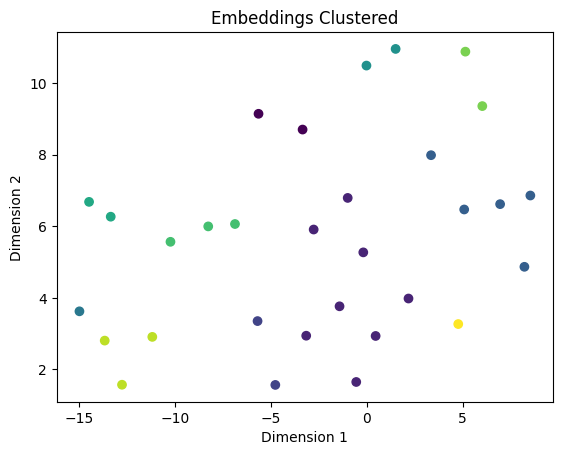

In [39]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Taking out the warnings
import warnings
from warnings import simplefilter

# Filter out FutureWarnings
simplefilter(action='ignore', category=FutureWarning)

# Perform t-SNE and reduce to 2 dimensions
tsne = TSNE(n_components=2, random_state=42, perplexity=11)
reduced_data_tsne = tsne.fit_transform(np_vector)

# Plot the reduced data
plt.scatter(reduced_data_tsne[:, 0], reduced_data_tsne[:, 1], c=kmeans.labels_)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Embeddings Clustered')
plt.show()

Agora precisamos obter os vetores que estão mais próximos dos centróides do cluster (o centro).

A função abaixo é uma maneira rápida de fazer isso (com ajuda do ChatGPT)

In [40]:
# Encontre os embeddings mais próximos dos centróides

# Crie uma lista vazia que conterá seus pontos mais próximos
closest_indices = []

# Faça um loop pelo número de clusters que você possui
for i in range(num_clusters):
    
     # Obtenha a lista de distâncias daquele centro de cluster específico
     distances = np.linalg.norm(vectors - kmeans.cluster_centers_[i], axis=1)
    
     # Encontre a posição da lista do mais próximo (usando argmin para encontrar a menor distância)
     closest_index = np.argmin(distances)
    
     # Anexe essa posição à sua lista de índices mais próximos
     closest_indices.append(closest_index)


Agora classifique-os (para que os pedaços sejam processados em ordem)

In [41]:
selected_indices = sorted(closest_indices)
selected_indices

[0, 6, 7, 10, 16, 18, 20, 25, 26, 28, 29]

Vamos criar nossos prompts personalizados. 

In [42]:
map_prompt = """
Você receberá uma única passagem de um livro. Esta seção será colocada entre crases triplos (```)
Seu objetivo é fornecer um resumo desta seção para que o leitor tenha uma compreensão completa do que aconteceu.
Sua resposta deve ter pelo menos três parágrafos e abranger totalmente o que foi dito na passagem.

```{text}```
RESUMO COMPLETO:"""
map_prompt_template = PromptTemplate(template=map_prompt, input_variables=["text"])

In [43]:
map_chain = load_summarize_chain(llm=llm,
                             chain_type="stuff",
                             prompt=map_prompt_template)

Em seguida, pegue seus documentos que representam os principais vetores.

In [44]:
selected_docs = [docs[doc] for doc in selected_indices]

Vamos percorrer nossos documentos selecionados e obter um bom resumo de cada parte. Armazenaremos o resumo em uma lista.

In [45]:
# Make an empty list to hold your summaries
summary_list = []

# Loop through a range of the lenght of your selected docs
for i, doc in enumerate(selected_docs):
    
    # Go get a summary of the chunk
    chunk_summary = map_chain.run([doc])
    
    # Append that summary to your list
    summary_list.append(chunk_summary)
    
    print (f"Resumo #{i} (chunk #{selected_indices[i]}) - prévia: {chunk_summary[:250]} \n")

Resumo #0 (chunk #0) - prévia: O projeto de pesquisa apresentado pelo graduando Thauan da Silva Cruz tem como objetivo automatizar a fiscalização de gastos públicos por meio da classificação automática de empenhos utilizando Aprendizado de Máquina. Através da utilização de algorit 

Resumo #1 (chunk #6) - prévia: O Tribunal de Contas do Estado de Goiás é responsável por fiscalizar os gastos públicos, mas a quantidade mensal de empenhos gerados pela administração pública torna essa tarefa inviável para os recursos humanos disponíveis. Por isso, este trabalho p 

Resumo #2 (chunk #7) - prévia: Aprendizado de Máquina é um processo em que se utiliza dados disponíveis para aprender padrões e realizar predições de novos dados. A representação dos dados é fundamental para expor suas características e facilitar o entendimento dos padrões pelos a 

Resumo #3 (chunk #10) - prévia: A seção apresenta uma analogia para explicar o método do Gradiente Descendente, que consiste em encontrar a direção 

Agora que temos nossa lista de resumos, vamos fazer um resumo dos resumos

In [46]:
from langchain.schema import Document

summaries = "\n".join(summary_list)

# Convert it back to a document
summaries = Document(page_content=summaries)

print (f"Seu resumo possui {llm.get_num_tokens(summaries.page_content)} tokens")

Seu resumo possui 4087 tokens


In [47]:
combine_prompt = """
Você receberá uma série de resumos de um documento. Os resumos serão colocados entre crases triplos (```)
Seu objetivo é fornecer um resumo detalhado do que aconteceu na história.
O leitor deve ser capaz de compreender o que aconteceu no documento.

```{text}```
RESUMO DETALHADO:
"""
combine_prompt_template = PromptTemplate(template=combine_prompt, input_variables=["text"])

In [48]:
reduce_chain = load_summarize_chain(llm=llm,
                             chain_type="stuff",
                             prompt=combine_prompt_template,
#                              verbose=True # Set this to true if you want to see the inner workings
                                   )

In [49]:
output = reduce_chain.run([summaries])

In [50]:
from pprint import pprint
pprint(output)

('O documento apresenta um projeto de pesquisa que visa automatizar a '
 'fiscalização de gastos públicos através da classificação automática de '
 'empenhos utilizando Aprendizado de Máquina. Foram utilizados algoritmos de '
 'classificação para identificar gastos suspeitos ou irregulares, otimizando o '
 'trabalho dos órgãos responsáveis pela fiscalização. A metodologia utilizada '
 'envolveu a remoção de empenhos e a manipulação dos atributos de um conjunto '
 'de dados do Tribunal de Contas do Estado de Goiás, gerando por volta de '
 '60.000 novos atributos. Foram explorados diferentes modelos de aprendizado '
 'de máquina e estratégias para utilizá-los de maneira mais eficiente, como '
 'Stacking e Oráculo. Foi apresentado um questionário sobre os campos '
 'presentes nos dados do TCE-GO, que forneceram informações sobre tipos de '
 'administração, poderes, função, subfunção, programa, ação, grupo e elemento '
 'de despesa, formalidade e modalidade de licitação. A seção também apr